<a href="https://colab.research.google.com/github/shaun-kee/Find_your_route/blob/master/Find_optimal_route.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup
## Installing dependencies

In [0]:
# install dependencies
!pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-3.0.2-cp36-none-any.whl size=31702 sha256=47908b1e77a458b67006be760415f6aff5cd365155c9a9c97403375a11a2ff37
  Stored in directory: /root/.cache/pip/wheels/3c/3f/25/ce6d7722dba07e5d4a12d27ab38f3d7add65ef43171b02c819
Successfully built googlemaps


## Importing libraries

In [0]:
# import libraries here
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import googlemaps
from google.colab import files

## Load PyDrive libraries
Install Colab dependencies to *use* Google Drive and Google API 

In [0]:
# my API KEY
API_key = 'INSERT API HERE'

# Import pydrive libraries for dataset load
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load Google Map API
gmaps = googlemaps.Client(key=API_key)

In [0]:
# Load dataset into colab
id_list = {'locations':'1Fr6xx0BrR1co-DZAofUurVkG4bUxjDVa',
           'distribution_centre':'1vcMlmJA0ww_1brHYxuXdA86v6XJTyyPW'}

for name, idx in id_list.items():
    id = idx
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('data_{}.csv'.format(name)) 

# Data integrity check
When checking the data in excel, pandas dataframe and in Google map, there are a few outliers that might be present in the dataset. 

Most datapoints lies within Cambodia but there are 5 data points that lies in France and US. These data points are removed from the dataset. 

**You can skip executing this portion and jump straight to clustering section.** 

**A pre-processed files have been saved into Google MyDrive for later use**

In [0]:
data_df = pd.read_csv('data_locations.csv')

print(data_df.dtypes, '\n')
print('Check if there are any null values: ', 
      data_df.Longitude.isnull().unique(), '\n')
print(data_df[data_df.Longitude.isnull()])

Parcels        int64
Latitude      object
Longitude    float64
dtype: object 

Check if there are any null values:  [False  True] 

      Parcels        Latitude  Longitude
1125     1126  Exchange Quare        NaN
1126     1127  Exchange Quare        NaN


In [0]:
delivery_points = data_df.drop([897,898,1125,1126,1190,1191,1189,1565])

# Using Distance Matrix API
Using Google's Distance Matrix API to extract the following information:


*   Distance between distribution centre to delivery point
*   Duration taken  
*   Destination address



In [0]:
distribution = pd.read_csv('data_distribution_centre.csv')

In [0]:
def get_dist(row):
    try:
        destination = (float(row.Latitude), row.Longitude)
        distribution_center = (distribution.Lat.values[0],
                               distribution.Long.values[0])
        results = gmaps.distance_matrix(distribution_center, destination, 
                                        mode='driving')        
        distance = results["rows"][0]["elements"][0]["distance"]["value"]
        return distance    

    except KeyError:
        return None

In [0]:
def get_duration(row):
    try:
        destination = (float(row.Latitude), row.Longitude)
        distribution_center = (distribution.Lat.values[0],
                               distribution.Long.values[0])
        results = gmaps.distance_matrix(distribution_center, destination, 
                                        mode='driving')        
        duration = results["rows"][0]['elements'][0]['duration']["value"] 
        return duration    

    except KeyError:
        return None       

In [0]:
def get_add(row):
    try:
        destination = (float(row.Latitude), row.Longitude)
        distribution_center = (distribution.Lat.values[0],
                               distribution.Long.values[0])
        results = gmaps.distance_matrix(distribution_center, destination, 
                                        mode='driving')        
        add = results['destination_addresses'][0]
        return add    

    except KeyError:
        return None       

In [0]:
delivery_points['Distance'] = delivery_points.apply(get_dist, axis=1)
delivery_points['Duration'] = delivery_points.apply(get_duration, axis=1)
delivery_points['Destination_Address'] = delivery_points.apply(get_add, axis=1)

## Descriptive Statisitcs
Check to see if there's any outlier or inconsistent data point

In [0]:
print(delivery_points[delivery_points.Distance.isnull()], '\n')
print(delivery_points.describe())

Empty DataFrame
Columns: [Parcels, Latitude, Longitude, Distance, Duration, Destination_Address]
Index: [] 

           Parcels    Longitude      Distance     Duration
count  1597.000000  1597.000000   1597.000000  1597.000000
mean    801.268629   104.910924   4533.430808  1014.603632
std     463.773529     0.025719   4051.766104   634.482514
min       1.000000   104.707982    457.000000   171.000000
25%     400.000000   104.901316   2142.000000   553.000000
50%     799.000000   104.919928   3197.000000   822.000000
75%    1205.000000   104.925561   6207.000000  1398.000000
max    1605.000000   105.008719  48526.000000  4680.000000


## Save preprocessed dataset for later use

In [0]:
# save dataset into csv file
delivery_points.to_csv('dataset.csv')

# upload csv into mydrive
dataset = drive.CreateFile({'parents' : [{u'id': '1JJQOQi6qojNS4JXCrMsfHAGWQTLrQayY'}]})
dataset.SetContentFile('dataset.csv')
dataset.Upload()

print (drive.CreateFile({'dataset.csv': dataset.get('id')}))

GoogleDriveFile({'dataset.csv': '1WJxBZIsjKdK0Af6j-M4DYhxA3_CxEMvH'})


# Using Clustering methods to determine driver's coverage area
Approach as follows: Will use 2 clustering methods (KMeans and DBScan) to see how the clusters look like for each driver


## Using KMeans
By looking at the different models, it appears that the best clustering is just by using the latitude and longitude to do the clustering for delivery points like this. However, features like duration and distance can be put into play for test cases where there is more than 1 well defined clusters or to break big clusters down into smaller clusters

In [0]:
# Load dataset into colab
id_list = {'dataset':'1WJxBZIsjKdK0Af6j-M4DYhxA3_CxEMvH'}

for name, idx in id_list.items():
    id = idx
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('{}.csv'.format(name))
    
delivery_points = pd.read_csv('dataset.csv')
delivery_points.Latitude = delivery_points.Latitude.astype(float)
delivery_points.drop('Unnamed: 0',inplace=True, axis=1)

In [0]:
delivery_points.sample(2)

,Parcels,Latitude,Longitude,Distance,Duration,Destination_Address
948,951,11.544024,104.923344,2611,817,"Mao Tse Toung Boulevard (245), Phnom Penh, Cam..."
1301,1309,11.549012,104.922259,2632,692,"51/53 St 352, Phnom Penh, Cambodia"


### Models

A few feature choices are tried and visualised using seaborn scatterplot. However, clustering of the delivery points still seem most reasonable just by using the latitude and longitude.

In [0]:
X = delivery_points[['Latitude','Longitude']]
model = KMeans(n_clusters=25, random_state = 2019, n_jobs=-1).fit(X)

In [0]:
X2 = delivery_points[['Latitude','Longitude','Distance']]
model2 = KMeans(n_clusters=25, random_state = 2019, n_jobs=-1).fit(X2)

In [0]:
X3 = delivery_points[['Latitude','Longitude','Duration']]
model3 = KMeans(n_clusters=25, random_state = 2019, n_jobs=-1).fit(X3)

In [0]:
X4 = delivery_points[['Distance','Duration']]
model4 = KMeans(n_clusters=25, random_state = 2019, n_jobs=-1).fit(X4)

In [0]:
delivery_points['KMeans_1'] = model.labels_
delivery_points['KMeans_2'] = model2.labels_
delivery_points['KMeans_3'] = model3.labels_
delivery_points['KMeans_4'] = model4.labels_

**Clustering visualisation**

Since there are 25 drivers, 25 clusters are stipulated as one of the hyperparameter for the prediction model. KMeans is able to cluster the delivery points fairly good. The downside of this clustering is that more concentrated delivery points will tend be to clustered together. Making the number of delivery points each driver needs to take imbalanced. 

As you can see, the further clusters actually receive less delivery points when compared to where most points are located together

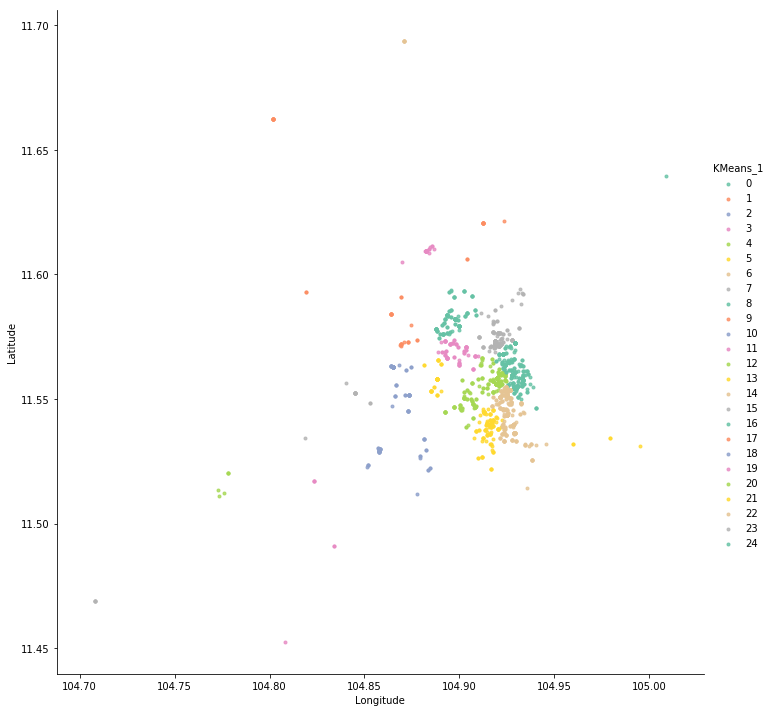

In [0]:
sns.lmplot(y='Latitude', x='Longitude', data=delivery_points, 
           hue='KMeans_1', palette='Set2', fit_reg=False, 
           height=10, aspect=1, markers ='.')

plt.show()

## Using DBScan
DBScan is not very good for this test case as it is not able to cluster delivery points that are on the outer skirts of the congregation of the delivery points. 

DBScan primarily tries to do even clusters based on the given radius parameter and treats all other points as outliers. This makes alot of delivery points to become unclassified as shown in class -1

In [0]:
scaled = MinMaxScaler().fit_transform(X4)
model5 = DBSCAN(eps=0.0048,min_samples=15).fit(scaled)
delivery_points['DBSCAN_1'] = model5.labels_

In [0]:
scaled2 = MinMaxScaler().fit_transform(X)
model6 = DBSCAN(eps=0.006,min_samples=10).fit(scaled2)
delivery_points['DBSCAN_2'] = model6.labels_

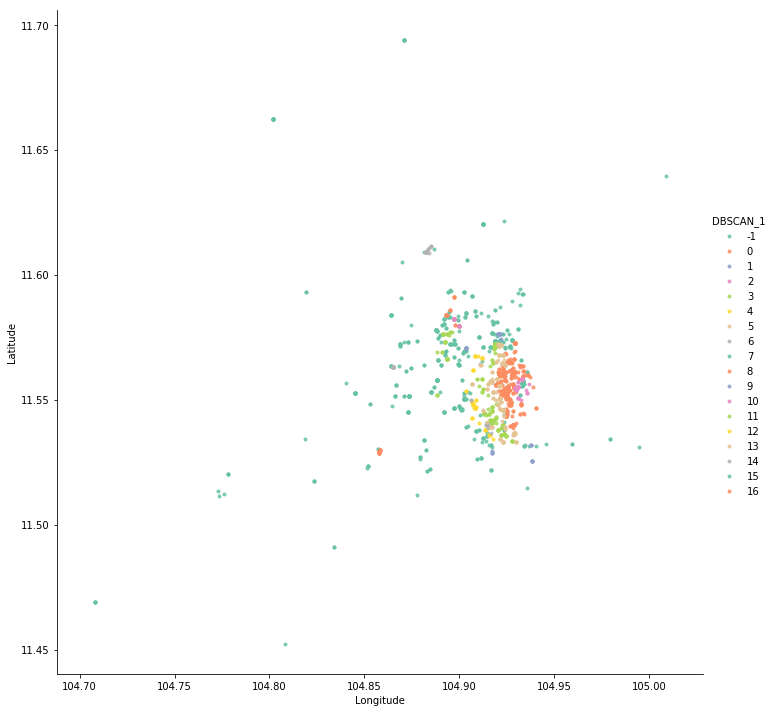

In [0]:
sns.lmplot(y='Latitude', x='Longitude', data=delivery_points, 
           hue='DBSCAN_1', palette='Set2', fit_reg=False, 
           height=10, aspect=1, markers ='.')

plt.show()

##Saving model labels into a dataset

Using KMeans as the primary clustering model, generated labels is combined back to the original dataset and saved as a csv for visualising in Google Map.

In [0]:
def saver_function(filename,name):
    # save dataset into csv file
    filename.to_csv('{}.csv'.format(name))

    # upload csv into mydrive
    dataset = drive.CreateFile({'parents' : [{u'id': '1JJQOQi6qojNS4JXCrMsfHAGWQTLrQayY'}]})
    dataset.SetContentFile('{}.csv'.format(name))
    dataset.Upload()

    print (drive.CreateFile({'{}.csv'.format(name): dataset.get('id')}))

In [0]:
saver_function(delivery_points,'routing_dataset')

GoogleDriveFile({'routing_dataset.csv': '10XGJsu-GSvgV06HNanmMg3dqKG38wRqp'})


#Planning driver's route

A simple method is segregate each cluster out and plan the route within each cluster, given the delivery points. 

This makes it a simple **travelling salesman problem** where a person needs to figure out the best possible way to make it to all given points based on distance/duration proximity for each point the person have take

## Prepping the data

More duplicates of the delivery points are removed to simplify the problem and coordinates of all the addresses are extracted before it is fed into a distance calculator to compute the distances. The distances of all points relative to the each delivery points is computed into a distance matrix

This distance matrix is then used to do the routing

In [0]:
id_list = {'routing_dataset':'10XGJsu-GSvgV06HNanmMg3dqKG38wRqp'}

for name, idx in id_list.items():
    id = idx
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('{}.csv'.format(name))
    
delivery_points = pd.read_csv('routing_dataset.csv')

In [0]:
'''
I realised that there are quite a number of duplicate delivery points 
(same latitude, longitude and destination address). I took the liberty to
remove them in order to make the algorithm work more smoothly.
Other than that I sort the point according to distance and duration and give
each entry a sequence number for better referencing.
'''

def simple_routing(driver):
    route = delivery_points[delivery_points['KMeans_1']==driver].copy()
    route = route.sort_values(by=['Distance','Duration'], ascending=True)
    route.drop_duplicates(['Latitude','Longitude'], keep='first',inplace=True)
    route['Sequence'] = np.arange(len(route))
    return route

In [0]:
'''
Extract only Latitude and Longitude coordinates from dataset
'''

def get_coordinates(num):
    dataset = simple_routing(num)
    coordinates = list(zip(dataset.Latitude.values,dataset.Longitude.values))
    return coordinates

In [0]:
'''
This is used to call out Distance Matrix API to calculate distance between
2 points
'''

def distance_calculator(origin, destination):
    try:
        results = gmaps.distance_matrix(origin, destination, 
                                        mode='driving')        
        distance = results["rows"][0]["elements"][0]["distance"]["value"]
        return distance    

    except KeyError:
        return None

In [0]:
'''
Results from get_coordinate function is fed into the distance_calculator 
function to compute the distances with respect to each point.
Distances are arranged in a distance matrix format
'''

def dist_matrix_row(addresses):
    empty_lst = []
    for num in np.arange(len(addresses)):
        row = [distance_calculator(addresses[num],latlong) for latlong in addresses]
        empty_lst.append(row)
    return empty_lst

## Computing the route

Based on the initial delivery point, this algorithm will decide which is the next nearest delivery point based on distance proximity. It will then select that as the next delivery point and will repeat the process until all delivery points have been reached.

In [0]:
'''
Takes the first delivery point (Sequence 0) and searches the next nearest 
delivery point by looking at the shortest distance. The index of the shortest 
distance will be used to find the sequence number of the next delivert point.

It then append the sequence number of the next delivery point as reference
and use the next delivery point to calculate the following nearest delivery
point. In order to prevent repetition, the algorithm will refer back to the
reference list and pops out distances related to the points that have alry 
been listed.
'''

def route_planner(matrix):
    sequence = [0]
    for num in np.arange(len(matrix)):
        idx = sequence[-1]
        lst = []
        
#         print('idx:',idx)
        
        array = np.array(matrix[idx])
        findzero = list(np.where(array==0)[0])
        
#         print('index of zero:',findzero)
        
        counter = 1
        first = True
        for i in findzero:
            if first == True:
                first = False
                pass
            else:
#                 print('num of i is:', i)
#                 print('matrix[i]:', matrix[i])
                matrix[idx][i] = matrix[idx][i] + counter
                counter += 1
        
        for dist in matrix[idx]:
            if dist != 0:
                lst.append(dist)                

        for num in sequence:
            distance = matrix[idx][num]
            try:
                lst.remove(distance)
            except ValueError:
                pass
            
#         print(lst)
        try:
            min_dist = np.min(lst)
            min_idx = matrix[idx].index(min_dist)
            sequence.append(min_idx)
        except ValueError:
            pass
    return sequence

In [0]:
def combiner(driver):
    delivery_coordinates = get_coordinates(driver)
    delivery_matrix = dist_matrix_row(delivery_coordinates)
    delivery_plan = route_planner(delivery_matrix)
    return delivery_plan, delivery_matrix, delivery_coordinates

### Testing code

In [0]:
x = np.array([1,0,20,0,330,0,4544,55,66,73,82])
ans = list(np.where(x==0)[0])
# ans = list(ans)
print(ans)
x = list(x)
print(x)

counter = 1
first = True
for idx in ans:
    if first == True:
        first = False
        pass
    else:
        x[idx] = x[idx] + counter
        counter += 1
        
print(x)

[1, 3, 5]
[1, 0, 20, 0, 330, 0, 4544, 55, 66, 73, 82]
[1, 0, 20, 1, 330, 2, 4544, 55, 66, 73, 82]


## Visualising the route

### Driver 1

In [0]:
driver1, driver1_matrix, driver1_coordinates = combiner(1)

In [0]:
print('The route of driver 1 is: \n',driver1)

The route of driver 1 is: 
 [0, 4, 1, 2, 6, 3, 5, 7, 8, 9, 10]


In [0]:
driver1_dataset = simple_routing(1)
driver1_dataset = driver1_dataset.reset_index()
driver1_dataset = driver1_dataset.reindex(driver1)
saver_function(driver1_dataset,'driver1_route')

GoogleDriveFile({'driver1_route.csv': '1KySg318AwrzPa8mkX17P73rFyupaR0wH'})


### Driver 7

In [0]:
driver7, driver7_matrix, driver7_coordinates = combiner(7)
print('The route of driver 7 is: \n',driver7)

The route of driver 7 is: 
 [0, 3, 8, 17, 21, 26, 29, 26, 30, 25, 32, 37, 36, 34, 35, 31, 39, 41, 42, 25, 32, 12, 5, 13, 14, 2, 1, 7, 11, 2, 15, 18, 22, 19, 20, 23, 9, 4, 9, 16, 6, 24, 28, 38, 40, 43, 45, 47, 48, 46, 44]


In [0]:
driver7_dataset = simple_routing(7)
driver7_dataset = driver7_dataset.reset_index()
driver7_dataset = driver7_dataset.reindex(driver7)
saver_function(driver7_dataset,'driver7_route')

GoogleDriveFile({'driver7_route.csv': '1YXU-0dF6dp9PcXeN-8DTXwh5qGxH63Cv'})


### Driver 8

In [0]:
driver8, driver8_matrix, driver8_coordinates = combiner(8)

In [0]:
print('The route of driver 8 is: \n',driver8)

The route of driver 8 is: 
 [0, 1, 9, 19, 9, 20, 30, 31, 34, 23, 25, 26, 27, 33, 35, 17, 32, 5, 6, 7, 3, 8, 11, 14, 29, 13, 21, 15, 22, 12, 18, 2, 4, 16, 24, 28]


In [0]:
driver8_dataset = simple_routing(8)
driver8_dataset = driver8_dataset.reset_index()
driver8_dataset = driver8_dataset.reindex(driver8)
saver_function(driver8_dataset,'driver8_route')

GoogleDriveFile({'driver8_route.csv': '14gXduD4r-CjoyEYtYOChrm7BdCCUrhU5'})


### Driver 21

In [0]:
driver21, driver21_matrix, driver21_coordinates = combiner(21)

In [0]:
print('The route of driver 21 is: \n',driver21)

The route of driver 21 is: 
 [0, 4, 5, 6, 3, 7, 8, 1, 2]


In [0]:
driver21_dataset = simple_routing(21)
driver21_dataset = driver21_dataset.reset_index()
driver21_dataset = driver21_dataset.reindex(driver21)
saver_function(driver21_dataset,'driver21_route')

GoogleDriveFile({'driver21_route.csv': '12FfE_GQVsaG6_R5-8qBVTS9b6Uw8ovX_'})


### Driver 10

In [0]:
driver10, driver10_matrix, driver10_coordinates = combiner(10)

In [0]:
print('The route of driver 10 is: \n',driver10)

The route of driver 10 is: 
 [0, 3, 4, 5, 6, 7, 1, 2, 8, 9]


In [0]:
driver10_dataset = simple_routing(10)
driver10_dataset = driver10_dataset.reset_index()
driver10_dataset = driver10_dataset.reindex(driver10)
saver_function(driver10_dataset,'driver10_route')

GoogleDriveFile({'driver10_route.csv': '15pOwNcRocEm1zfcJYDKOWB4lpPSgaQ3B'})
